[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/5_IntroGNN.ipynb)

# Introduction to Graph Neural Nets with JAX/jraph

References:
- A Gentle Introduction to Graph Neural Networks ([link](https://distill.pub/2021/gnn-intro/))
- Graph Theory basics (MIT Open Courseware [slides](https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-022-introduction-to-network-models-fall-2018/lecture-notes/MIT1_022F18_lec2.pdf) by Amir Ajorlou)

In [ ]:
#!pip install git+https://github.com/deepmind/jraph.git

In [2]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jraph
from jraph import GraphConvolution
from flax import nnx
import optax
import networkx as nx
import logging
from tqdm.notebook import tqdm # progress bar

logging.basicConfig(level=logging.INFO)

## Fundamental Graph Theory concepts
A graph consists of a set of nodes and a set of edges, where edges form connections
between nodes. More formally, a graph is a pair $ \mathcal{G} = (\mathcal{V},
\mathcal{E})$ where $\mathcal{V}$ is the set of vertices / nodes, and $\mathcal{E}$ is
the set of edges.

In an **undirected** graph, each edge is an unordered pair of two nodes $ \in
\mathcal{V}$. E.g. a friend network can be represented as an undirected graph, assuming
that the relationship "*A is friends with B*" implies "*B is friends with A*". In a
**directed** graph (or **digraph**), each edge is an ordered pair of nodes $ \in \mathcal{V}$. E.g. a
citation network would be best represented with a directed graph, since the relationship
"*A cites B*" does not imply "*B cites A*".

The **degree** of a node is defined as the number of edges incident on it, i.e. the sum
of incoming and outgoing edges for that node (in an undirected graph it is simply the
number of edges connected to it).

There are several ways to represent $\mathcal{E}$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$.
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|\mathcal{V}| \times |\mathcal{V}|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|\mathcal{V}|$ unordered lists, where the $i$-th list corresponds to the $i$-th node, and contains all the nodes directly connected to node $i$.


Example: Below is a directed graph with four nodes and five edges.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="400px">

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$



## Graph Prediction Tasks

The _classification_ tasks fall into roughly three categories (analogous tasks for _regression_):

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*The three main graph learning tasks. Image source: Petar Veličković.*

## The `jraph` library

[`jraph`](https://github.com/deepmind/jraph) is a lightweight library for working with GNNs in [JAX](https://github.com/google/jax).

In `jraph`, a graph is represented with a `GraphsTuple` object. In addition to defining the graph structure of nodes and edges, you can also store node features, edge features and global graph features in a `GraphsTuple`.

In the `GraphsTuple`, edges are represented in two aligned arrays of node indices: senders (source nodes) and receivers (destinaton nodes).
Each index corresponds to one edge, e.g. edge `i` goes from `senders[i]` to `receivers[i]`.

We will start with creating a simple directed graph with 4 nodes and 5 edges. We will also add toy features to the nodes, using `2*node_index` as the feature.

We will later use this toy graph in the GCN demo.

In [3]:
def build_toy_graph() -> jraph.GraphsTuple:
  """Define a four node graph, each node has a scalar as its feature."""

  # Nodes are defined implicitly by their features.
  # We will add four nodes, each with a feature, e.g.
  # node 0 has feature [0.],
  # node 1 has featre [2.] etc.
  # len(node_features) is the number of nodes.
  node_features = jnp.array([[0.], [2.], [4.], [6.]])

  # We will now specify 5 directed edges connecting the nodes we defined above.
  # We define this with `senders` (source node indices) and `receivers`
  # (destination node indices).
  # For example, to add an edge from node 0 to node 1, we append 0 to senders,
  # and 1 to receivers.
  # We can do the same for all 5 edges:
  # 0 -> 1
  # 1 -> 2
  # 2 -> 0
  # 3 -> 0
  # 0 -> 3
  senders = jnp.array([0, 1, 2, 3, 0])
  receivers = jnp.array([1, 2, 0, 0, 3])

  # You can optionally add edge attributes to the 5 edges.
  edges = jnp.array([[5.], [6.], [7.], [8.], [8.]])

  # We then save the number of nodes and the number of edges.
  # This information is used to make running GNNs over multiple graphs
  # in a GraphsTuple possible.
  n_node = jnp.array([4])
  n_edge = jnp.array([5])

  # Optionally you can add `global` information, such as a graph label.
  global_context = jnp.array([[1]]) # Same feature dims as nodes and edges.
  graph = jraph.GraphsTuple(
      nodes=node_features,
      edges=edges,
      senders=senders,
      receivers=receivers,
      n_node=n_node,
      n_edge=n_edge,
      globals=global_context
      )
  return graph

In [4]:
graph = build_toy_graph()

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


We can get different information by inspecting the `GraphTuple` object.

In [5]:
# Number of nodes
# Note that `n_node` returns an array. The length of `n_node` corresponds to
# the number of graphs stored in one `GraphsTuple`.
# In this case, we only have one graph, so n_node has length 1.
graph.n_node

Array([4], dtype=int32)

In [6]:
# Number of edges
graph.n_edge

Array([5], dtype=int32)

In [7]:
# Node features
graph.nodes

Array([[0.],
       [2.],
       [4.],
       [6.]], dtype=float32)

In [8]:
# Edge features
graph.edges

Array([[5.],
       [6.],
       [7.],
       [8.],
       [8.]], dtype=float32)

In [9]:
# Edges
graph.senders

Array([0, 1, 2, 3, 0], dtype=int32)

In [10]:
graph.receivers

Array([1, 2, 0, 0, 3], dtype=int32)

In [11]:
# Graph-level features
graph.globals

Array([[1]], dtype=int32)

To visualize the graph structure of the graph we created above, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

In [12]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

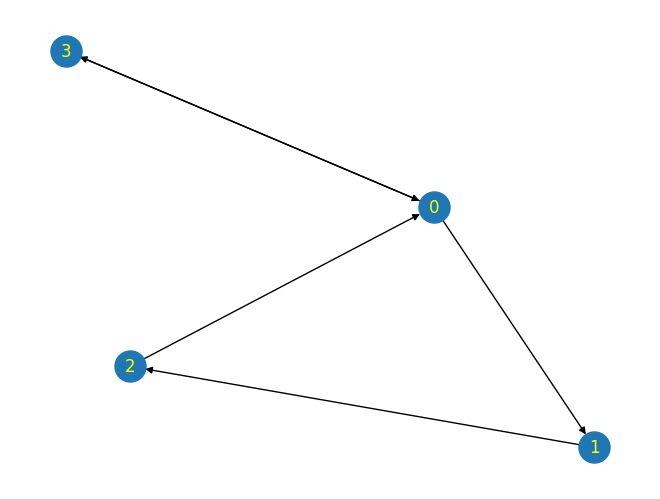

In [13]:
draw_jraph_graph_structure(graph)

## Graph Convolutional Networks (GCNs)

The graph convolutional network, introduced by by Kipf et al. (2017)
[paper](https://arxiv.org/abs/1609.02907), is one of the basic and most important graph network
architectures. 

GCNs have some analogies with convolutional neural networks (CNNs). In a CNN, a convolutional filter (e.g. 3x3) is applied
repeatedly to different parts of a larger input (e.g. 64x64) by striding across the
input. In a GCN, a convolution filter is applied to the neighbourhoods around a node in
a graph.

However, there are also some differences to point out:
In contrast to the CNN filter, the neighbourhoods in a GCN can be of different sizes, and there is no ordering of inputs. To see that, note that the CNN filter performs a weighted sum aggregation over the inputs with learnable weights, where each filter input has its own weight. In the GCN, the same weight is applied to all neighbours and the aggregation function is not learned. In other words, in a GCN, each neighbor contributes equally. This is why the CNN filter is not order-invariant, but the GCN filter is.

More specifically, the GCN layer performs two steps:

1. _Compute messages / update node features_: Create an (embedded) feature vector
   $\vec{h}_n$ for each node $n$ (e.g. with an MLP or simply a linear layer). This is going to be the message
   that this node will pass to neighboring nodes.
2. _Message-passing / aggregate node features_: For each node, calculate a new feature vector $\vec{h}'_n$ based on the messages (features) from the nodes in its neighborhood. In a directed graph, only nodes from incoming edges are counted as neighbors. The image below shows this aggregation step. There are multiple options for aggregation in a GCN, e.g. taking the mean, the sum, the min or max. 

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_conv.png" width="500px">

*\"A generic overview of a graph convolution operation, highlighting the relevant information for deriving the next-level features for every node in the graph.\"* Image source: Petar Veličković (https://github.com/PetarV-/TikZ)


The node feature update equation in a GCN for node $i$ at layer $l+1$ can be written as a summation over its neighboring nodes:

$$
h_i^{(l+1)} = \sigma\left( \sum_{j \in \mathcal{N}(i) \cup \{i\}} \frac{1}{\sqrt{d_i d_j}} W^{(l)} h_j^{(l)} \right)
$$

Where:
- $ h_i^{(l+1)} $ is the updated feature vector of node $ i $ at layer $ l+1 $.
- $ \mathcal{N}(i) $ represents the set of neighboring nodes of node $ i $.
- $ W^{(l)} $ is the learnable weight matrix at layer $ l $.
- $ h_j^{(l)} $ is the feature vector of node $ j $ at layer $ l $ (for the first layer,
  it is the input feature $ x_j $).
- $ d_i $ and $ d_j $ are the degrees of nodes $i$ and $j$, respectively.
  These normalization factors assign more weights to nodes with few neighbours to avoid
  features of nodes with lots of neighbours spread too easily.
- $ \sigma $ is a non-linear activation function (such as ReLU).

In [14]:
# Definition of a GCN layer in jraph
gcn_layer = GraphConvolution(
    update_node_fn=lambda x: x,
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    symmetric_normalization=True
)
print(graph)
gcn_layer(graph)

GraphsTuple(nodes=Array([[0.],
       [2.],
       [4.],
       [6.]], dtype=float32), edges=Array([[5.],
       [6.],
       [7.],
       [8.],
       [8.]], dtype=float32), receivers=Array([1, 2, 0, 0, 3], dtype=int32), senders=Array([0, 1, 2, 3, 0], dtype=int32), globals=Array([[1]], dtype=int32), n_node=Array([4], dtype=int32), n_edge=Array([5], dtype=int32))


GraphsTuple(nodes=Array([[4.082483  ],
       [0.99999994],
       [2.9999998 ],
       [2.9999998 ]], dtype=float32), edges=Array([[5.],
       [6.],
       [7.],
       [8.],
       [8.]], dtype=float32), receivers=Array([1, 2, 0, 0, 3], dtype=int32), senders=Array([0, 1, 2, 3, 0], dtype=int32), globals=Array([[1]], dtype=int32), n_node=Array([4], dtype=int32), n_edge=Array([5], dtype=int32))

So far our graph convolution operation doesn't have any learnable parameters.
Let's add an MLP block to the update function to make it trainable.

In [15]:
class MLP(nnx.Module):
  def __init__(self, out_features, rngs: nnx.Rngs):
    self.layers = []
    self.layers.append(nnx.Linear(1, 8, rngs=rngs))
    self.layers.append(nnx.relu)
    self.layers.append(nnx.Linear(8, out_features, rngs=rngs))

  def __call__(self, x):
    y = x
    for layer in self.layers:
      y = layer(y)
    return y

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(out_features=4, rngs=nnx.Rngs(0))(x)

In [16]:
# Test a GCN layer with non-linear embedding of node features
gcn_layer = GraphConvolution(
    update_node_fn=lambda n: MLP(out_features=4, rngs=nnx.Rngs(1))(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    symmetric_normalization=True
)

gcn_layer(graph)

GraphsTuple(nodes=Array([[ 0.6297602 ,  1.5241127 ,  2.1311328 , -1.8677307 ],
       [ 0.15425913,  0.37332982,  0.5220188 , -0.45749876],
       [ 0.46277738,  1.1199894 ,  1.5660564 , -1.3724962 ],
       [ 0.46277732,  1.1199895 ,  1.5660564 , -1.3724961 ]],      dtype=float32), edges=Array([[5.],
       [6.],
       [7.],
       [8.],
       [8.]], dtype=float32), receivers=Array([1, 2, 0, 0, 3], dtype=int32), senders=Array([0, 1, 2, 3, 0], dtype=int32), globals=Array([[1]], dtype=int32), n_node=Array([4], dtype=int32), n_edge=Array([5], dtype=int32))

## Exercise: Node Classification with GCN on Karate Club Dataset

### Zachary's Karate Club Dataset

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a small dataset commonly used as an example for a social graph. 

A node represents a student or instructor in the club. An edge means that those two people have interacted outside of the class. There are two instructors in the club.

Each student is assigned to one of two instructors.

The task is to predict the assignment of students to instructors, given the social graph
and only knowing a few connections. In other words, out of the 34 nodes, only some nodes are labeled, and we are trying to optimize the assignment of the other nodes, by **maximizing the log-likelihood of the two known node assignments**.

We will compute the accuracy of our node assignments by comparing to the ground-truth assignments. **Note that the ground-truth for the other student nodes is not used in the loss function itself.**

Let's load the dataset:

In [17]:
def get_zacharys_karate_club() -> jraph.GraphsTuple:
  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [18]:
graph = get_zacharys_karate_club()

In [19]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 34
Number of edges: 156


Visualize the karate club graph with circular node layout:

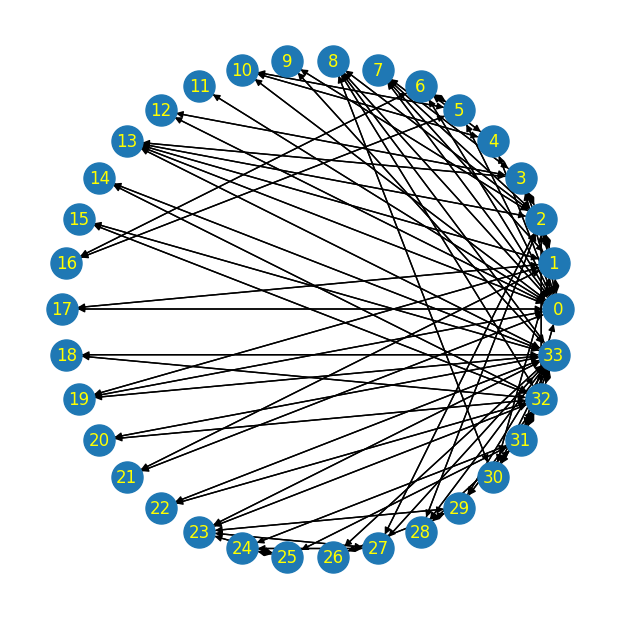

In [20]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

In [21]:
import numpy as np
mask = np.ones(len(graph.nodes))
mask[1:31]=0.

labels = get_ground_truth_assignments_for_zacharys_karate_club()

# Loss function
@nnx.jit
def loss_fn(model, graph, labels):
    output_graph_nodes = model(graph)
    loss = optax.losses.softmax_cross_entropy_with_integer_labels(output_graph_nodes, labels)
    return jnp.mean(loss*mask)

1. Define the GCN architecture
2. Implement the training functions
3. Train the GCN  
4. Evaluate the accuracy of the model

Define the GCN architecture:

In [22]:
#@title Model architecture:

class GCN(nnx.Module):
  def __init__(self, in_features, rngs: nnx.Rngs):
    self.layer1 = nnx.Linear(in_features, 8, rngs=rngs)
    self.layer2 = nnx.Linear(8, 2, rngs=rngs)

  def __call__(self, graph):
    self._gn1 = GraphConvolution(update_node_fn=lambda x: nnx.relu(self.layer1(x)),
                                add_self_edges=True)
    self._gn2 = GraphConvolution(update_node_fn=self.layer2)
    y = self._gn1(graph)
    y = self._gn2(y)
    return y.nodes

In [23]:
#@title Training functions:

# Train for a single epoch
@nnx.jit
def train_step(model, optimizer, graph, labels):
    loss, grads = nnx.value_and_grad(loss_fn)(model, graph, labels)
    optimizer.update(grads)
    return loss

def train(model, optimizer, graph, labels, epochs, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        train_loss = train_step(model, optimizer, graph, labels)

        output_graph_nodes = model(graph)
        accuracy =  jnp.mean(jnp.argmax(output_graph_nodes, axis=1) == labels)
        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            logging.info(
                "epoch:% 3d, train_loss: %.4f, accuracy: %.2f"
                % (epoch, train_loss, accuracy)
            )
    return train_loss_history

In [24]:
#@title Model training:
model = GCN(len(graph.nodes),rngs=nnx.Rngs(1))

# Define the optimizer
lr = 1e-2 # learning rate
optimizer = nnx.Optimizer(model, optax.adam(lr)) # Adam optimizer

epochs = 100

train_loss_history = train(model, optimizer, graph, labels, epochs, log_period_epoch=10, show_progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:epoch:  1, train_loss: 0.0808, accuracy: 0.50
INFO:root:epoch: 10, train_loss: 0.0611, accuracy: 0.50
INFO:root:epoch: 20, train_loss: 0.0440, accuracy: 0.68
INFO:root:epoch: 30, train_loss: 0.0252, accuracy: 0.88
INFO:root:epoch: 40, train_loss: 0.0109, accuracy: 0.91
INFO:root:epoch: 50, train_loss: 0.0043, accuracy: 0.94
INFO:root:epoch: 60, train_loss: 0.0019, accuracy: 0.94
INFO:root:epoch: 70, train_loss: 0.0010, accuracy: 0.94
INFO:root:epoch: 80, train_loss: 0.0007, accuracy: 0.94
INFO:root:epoch: 90, train_loss: 0.0005, accuracy: 0.94
INFO:root:epoch: 100, train_loss: 0.0004, accuracy: 0.94


In [25]:
output_nodes = model(graph)
predictions = jnp.argmax(output_nodes, axis=1)
print(predictions)
print(labels)

[0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


Visualize ground truth and predicted node assignments:

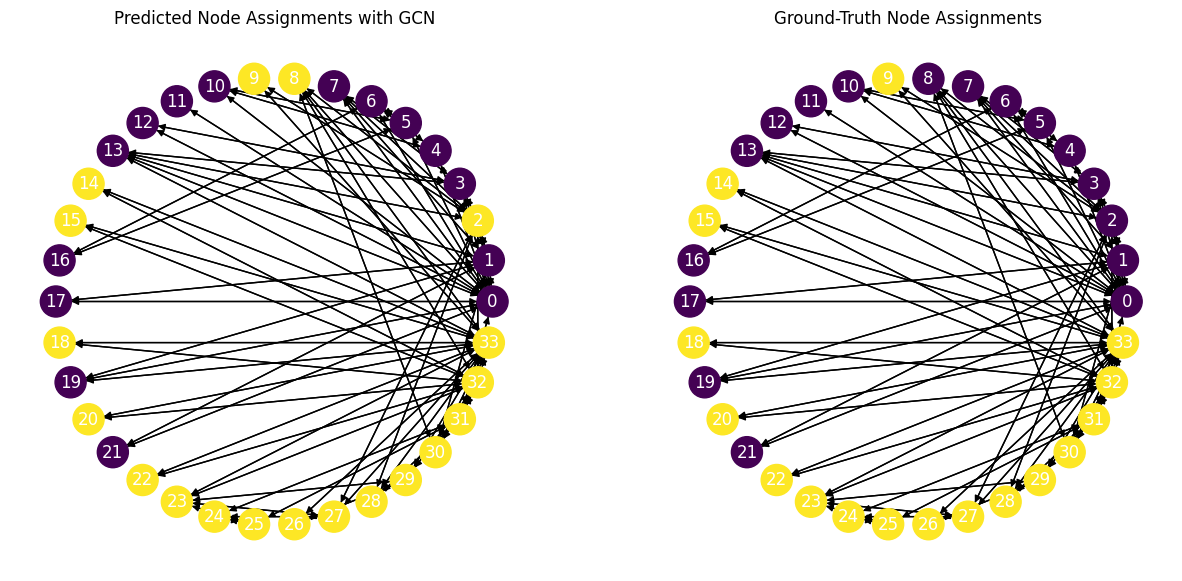

In [26]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=predictions.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN')

ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')

plt.show()

**Bonus exercise**: solve a node classification task on the
[`Cora`](https://medium.com/@koki_noda/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f)
dataset. Hint: use `PyTorch Geometric` to download the dataset and build a graph data
structure, then convert it into a `GraphTuple`. Use a GCN with two graph convolutional
layers and hidden dimension equal to 16. 